# Railvision project

Link: https://www.kaggle.com/datasets/tthien/shanghaitech

## Library

In [ ]:
# Library Umum
import os
import shutil
import zipfile
import random
import pathlib
from glob import glob
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numerik & Data
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Pemrosesan Gambar
import cv2
from PIL import Image
import skimage
from skimage.transform import resize
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

# Anotasi & Density Map
import scipy.io as sio
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter

# Tensorflow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Exploration

In [ ]:
# Import module kebutuhan upload file dan upload file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrayhanrasyad","key":"b69d6e04fae2e4b48479328522e18740"}'}

In [ ]:
# Download dataset dari kaggle lalu di unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech
!unzip shanghaitech.zip

Dataset URL: https://www.kaggle.com/datasets/tthien/shanghaitech
License(s): unknown
 96% 319M/333M [00:05<00:00, 46.3MB/s]
100% 333M/333M [00:05<00:00, 66.7MB/s]
Archive:  shanghaitech.zip
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_101.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_102.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_103.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_104.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_105.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_106.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_107.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_108.mat  
  inflatin

In [ ]:
# Penggabungan Part A dan Part B
from glob import glob

# Part A
a_img_dir_train = '/content/ShanghaiTech/part_A/train_data/images'
a_img_dir_test  = '/content/ShanghaiTech/part_A/test_data/images'
a_gt_dir_train  = '/content/ShanghaiTech/part_A/train_data/ground-truth'
a_gt_dir_test   = '/content/ShanghaiTech/part_A/test_data/ground-truth'

# Part B
b_img_dir_train = '/content/ShanghaiTech/part_B/train_data/images'
b_img_dir_test  = '/content/ShanghaiTech/part_B/test_data/images'
b_gt_dir_train  = '/content/ShanghaiTech/part_B/train_data/ground-truth'
b_gt_dir_test   = '/content/ShanghaiTech/part_B/test_data/ground-truth'

# Kumpulkan semua gambar dan ground truth dari Part A & B
image_paths = sorted(
    glob(a_img_dir_train + '/*.jpg') +
    glob(a_img_dir_test  + '/*.jpg') +
    glob(b_img_dir_train + '/*.jpg') +
    glob(b_img_dir_test  + '/*.jpg')
)

gt_paths = sorted(
    glob(a_gt_dir_train + '/*.mat') +
    glob(a_gt_dir_test  + '/*.mat') +
    glob(b_gt_dir_train + '/*.mat') +
    glob(b_gt_dir_test  + '/*.mat')
)

print(f"Total gambar ditemukan: {len(image_paths)}")
print(f"Total ground truth ditemukan: {len(gt_paths)}")

Total gambar ditemukan: 1198
Total ground truth ditemukan: 1198


In [ ]:
# Memastikan gambar dan ground truth cocok
print(image_paths[0])
print(gt_paths[0])

/content/ShanghaiTech/part_A/test_data/images/IMG_1.jpg
/content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat


## Preprocessing

### Split Dataset

In [ ]:
TEST_SIZE = 0.2
VAL_SIZE = 0.1
RANDOM_SEED = 42

# Split data test dan train
train_imgs, test_imgs, train_gts, test_gts = train_test_split(
    image_paths, gt_paths, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

# Split data val dari sisa train
train_imgs, val_imgs, train_gts, val_gts = train_test_split(
    train_imgs, train_gts, test_size=VAL_SIZE / (1 - TEST_SIZE), random_state=RANDOM_SEED
)

print(f"Train: {len(train_imgs)}")
print(f"Val  : {len(val_imgs)}")
print(f"Test : {len(test_imgs)}")

Train: 838
Val  : 120
Test : 240


### Load Sample

In [ ]:
def load_sample(img_path, mat_path):
    # Membaca gambar asli
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Gambar tidak bisa dibaca: {img_path}")

    # Load koordinat dari file .mat
    mat = loadmat(mat_path)

    # Mengambil koordinat titik (x,y) dari struktur image_info
    try:
        points = mat['image_info'][0, 0][0, 0][0]  # Ambil lokasi titik
        points = points.astype(np.float32)
    except Exception as e:
        raise ValueError(f"Ground truth tidak valid untuk file: {mat_path}\n{e}")

    return img, points

### Density Map Generation

In [ ]:
IMG_SIZE    = (256, 256)
SIGMA       = 15
BATCH_SIZE  = 8

# Membuat density map dari titik anotasi
def create_density_map(shape, points, sigma=SIGMA):
    h, w = shape[:2]
    density = np.zeros((h, w), dtype=np.float32)
    for x, y in points:
        if 0 <= int(y) < h and 0 <= int(x) < w:
            density[int(y), int(x)] = 1
    return gaussian_filter(density, sigma=sigma, mode='constant')

### Data Augmentation & Normalization

In [ ]:
# Memproses gambar dan anotasi ke ukuran/model input
def preprocess(img, points, img_size=IMG_SIZE):
    h0, w0 = img.shape[:2]
    img_r = cv2.resize(img, img_size)
    sx, sy = img_size[1] / w0, img_size[0] / h0

    pts = points.copy()
    pts[:, 0] *= sx
    pts[:, 1] *= sy

    img_n = img_r.astype(np.float32) / 255.0

    density = create_density_map(img_size, pts)

    if random.random() < 0.5:
        img_n = cv2.flip(img_n, 1)
        density = cv2.flip(density, 1)

    return img_n, density[..., None]

### Batch Generator

In [ ]:
# Generator data dalam batch
def data_generator(img_paths, gt_paths, batch_size=BATCH_SIZE, shuffle=True):
    idxs = list(range(len(img_paths)))
    while True:
        if shuffle:
            random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            batch = idxs[i:i+batch_size]
            X, Y = [], []
            for j in batch:
                try:
                    img, pts = load_sample(img_paths[j], gt_paths[j])
                    xi, yi   = preprocess(img, pts)
                    X.append(xi)
                    Y.append(yi)
                except Exception as e:
                    print(f"Gagal memproses:\n- Gambar: {img_paths[j]}\n- GT: {gt_paths[j]}\nError: {e}")
            if X and Y:
                yield np.stack(X, 0), np.stack(Y, 0)

In [ ]:
# Inisialisasi generator untuk training dan validasi
train_gen = data_generator(train_imgs, train_gts, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = data_generator(val_imgs,   val_gts,   batch_size=BATCH_SIZE, shuffle=False)

### Visualisasi Sample

Shape X: (8, 256, 256, 3)
Shape Y: (8, 256, 256, 1)


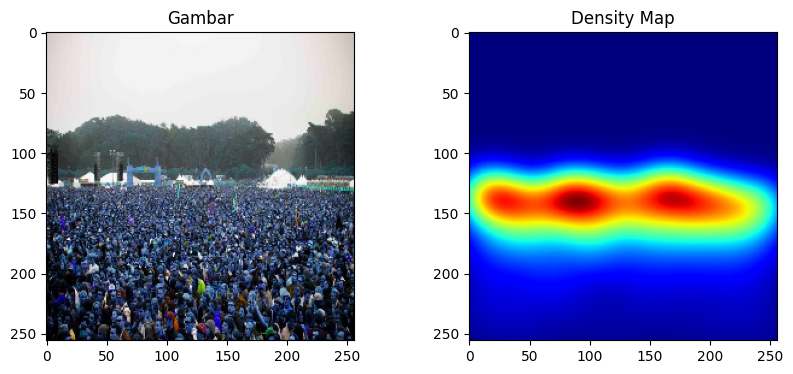

In [ ]:
X_batch, Y_batch = next(train_gen)
print("Shape X:", X_batch.shape)
print("Shape Y:", Y_batch.shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_batch[0])
plt.title("Gambar")

plt.subplot(1, 2, 2)
plt.imshow(Y_batch[0].squeeze(), cmap='jet')
plt.title("Density Map")

plt.show()

## Model Development & Training

### CSRNet: Model Development

In [ ]:
def build_csrnet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Feature Extraction
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)  # 256 -> 128

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)  # 128 -> 64

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)  # 64 -> 32

    # Dilated Convolutions
    x = layers.Conv2D(512, 3, padding='same', activation='relu', dilation_rate=2)(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu', dilation_rate=2)(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu', dilation_rate=2)(x)

    # Up-sampling untuk kembali ke resolusi awal
    x = layers.UpSampling2D(size=(2,2))(x)  # 32 -> 64
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2,2))(x)  # 64 -> 128
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D(size=(2,2))(x)  # 128 -> 256
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    output = layers.Conv2D(1, 1, padding='same', activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = build_csrnet(input_shape=(256, 256, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,184,065 (35.03 MB)

 Trainable params: 9,184,065 (35.03 MB)

 Non-trainable params: 0 (0.00 B)

### CSRNet: Model Training

In [ ]:
# Menghitung jumlah langkah per epoch berdasarkan ukuran dataset dan batch size
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

# Callback jika val_loss tidak berubah
earlystop = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)

# Training model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[earlystop, reduce_lr],
    verbose=1
)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 101s 641ms/step - loss: 8.6479e-05 - mae: 0.0044 - val_loss: 5.7522e-05 - val_mae: 0.0028 - learning_rate: 1.0000e-04
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 305ms/step - loss: 5.0427e-05 - mae: 0.0032 - val_loss: 6.3499e-05 - val_mae: 0.0034 - learning_rate: 1.0000e-04
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - loss: 8.4469e-05 - mae: 0.0043 - val_loss: 6.4447e-05 - val_mae: 0.0058 - learning_rate: 1.0000e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 8.1051e-05 - mae: 0.0043
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - loss: 8.1011e-05 - mae: 0.0043 - val_loss: 6.1380e-05 - val_mae: 0.0043 - learning_rate: 1.0000e-04
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - loss: 8.8403e-05 - mae: 0.0046 - val_loss: 4.5148e-05 - val_mae: 0.0037 - learning_rate: 5.0000e-05
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - loss:

## Evaluation

In [ ]:
# Mengevaluasi model berdasarkan counting error
y_true_counts = []
y_pred_counts = []

for i in range(validation_steps):
    batch_x, batch_y = next(val_gen)
    y_pred = model.predict(batch_x)

    for true_map, pred_map in zip(batch_y, y_pred):
        y_true_counts.append(np.sum(true_map))
        y_pred_counts.append(np.sum(pred_map))

# Menghitung metrik evaluasi berdasarkan jumlah
mae = mean_absolute_error(y_true_counts, y_pred_counts)
mse = mean_squared_error(y_true_counts, y_pred_counts)

print(f"MAE (Count): {mae:.2f}")
print(f"MSE (Count): {mse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
MAE (Count): 88.42
MSE (Count): 26920.36


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


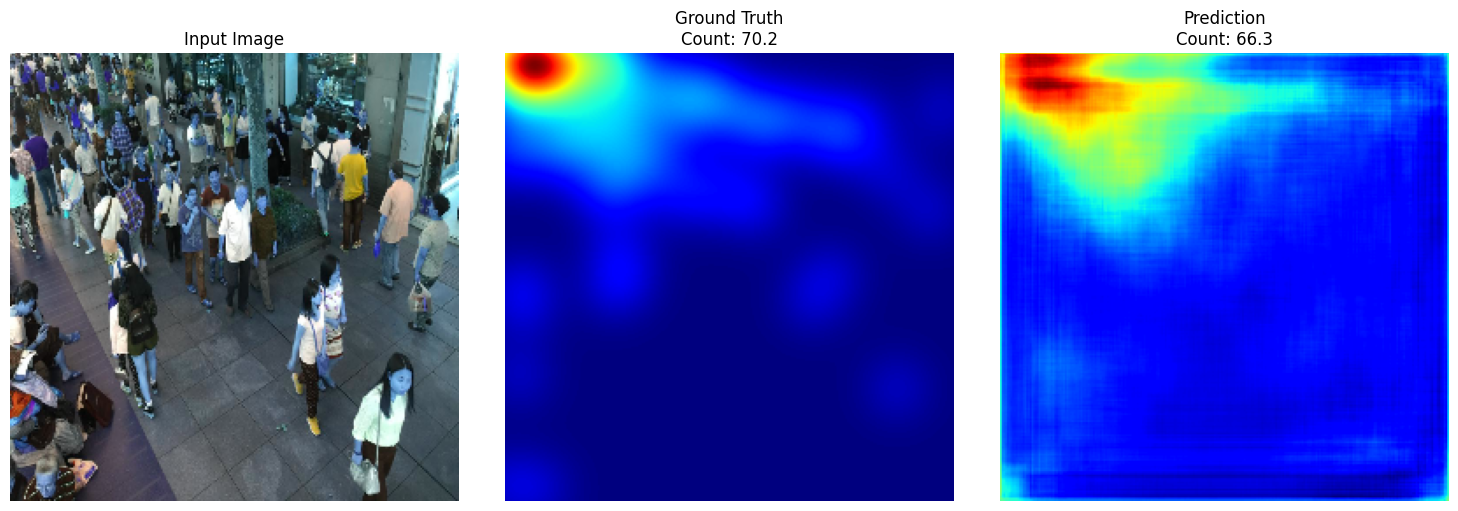

In [ ]:
# Visualisasi satu sample dari validation set
sample_x, sample_y = next(iter(val_gen))
pred_y = model.predict(sample_x)


i = 0

plt.figure(figsize=(15, 5))

# Menampilkan gambar asli
plt.subplot(1, 3, 1)
img_show = (sample_x[i] * 255).astype(np.uint8)
plt.imshow(img_show)
plt.title("Input Image")
plt.axis('off')

# Menampilkan ground truth density map
plt.subplot(1, 3, 2)
plt.imshow(sample_y[i].squeeze(), cmap='jet')
plt.title(f"Ground Truth\nCount: {np.sum(sample_y[i]):.1f}")
plt.axis('off')

# Menampilkan prediksi density map
plt.subplot(1, 3, 3)
plt.imshow(pred_y[i].squeeze(), cmap='jet')
plt.title(f"Prediction\nCount: {np.sum(pred_y[i]):.1f}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Inference

In [ ]:
# Mengupload gambar eksternal untuk inferensi
from google.colab import files
uploaded = files.upload()

Saving Inference tanah abang.jpeg to Inference tanah abang.jpeg


In [ ]:
img_path = list(uploaded.keys())[0]

# Preprocess gambar eksternal
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, IMG_SIZE)

img_norm = img_resized.astype(np.float32) / 255.0
input_tensor = np.expand_dims(img_norm, axis=0)

# Prediksi density map
pred_density = model.predict(input_tensor)[0].squeeze()
pred_count = np.sum(pred_density)

# Mengklasifikasi berdasarkan jumlah prediksi
def classify_density(count):
    if count < 10:
        return "Sangat Sepi"
    elif count < 30:
        return "Sepi"
    elif count < 60:
        return "Sedang"
    elif count < 100:
        return "Padat"
    else:
        return "Sangat Padat"

density_class = classify_density(pred_count)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


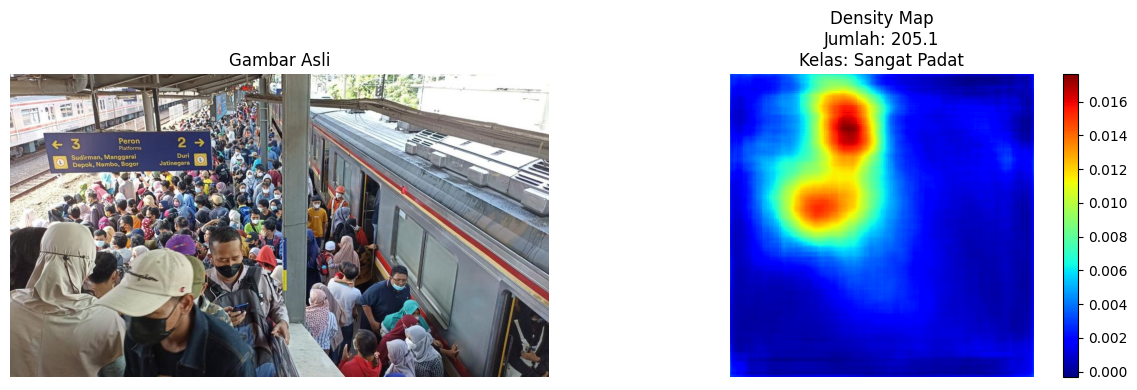

In [ ]:
# Memvisualisasi hasil inferensi
plt.figure(figsize=(12, 4))

# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Gambar Asli")
plt.axis('off')

# Density map serta prediksi jumlah dan kelas
plt.subplot(1, 2, 2)
plt.imshow(pred_density, cmap='jet')
plt.title(f"Density Map\nJumlah: {pred_count:.1f}\nKelas: {density_class}")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

## Menyimpan Model

### Saved model

In [ ]:
model.export("saved_model/csrnet_model")
print("Model berhasil diekspor ke 'saved_model/csrnet_model'")

Saved artifact at 'saved_model/csrnet_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  136018953858960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136018953854160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136018953859152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248329296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136018953862800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248329872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248329104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248328912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248330832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136017248331792: TensorSpec(shape=(), dtype=tf.resource, name=None

In [ ]:
!zip -r csrnet_saved_model.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/csrnet_model/ (stored 0%)
  adding: saved_model/csrnet_model/variables/ (stored 0%)
  adding: saved_model/csrnet_model/variables/variables.index (deflated 71%)
  adding: saved_model/csrnet_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/csrnet_model/saved_model.pb (deflated 89%)
  adding: saved_model/csrnet_model/assets/ (stored 0%)
  adding: saved_model/csrnet_model/fingerprint.pb (stored 0%)


In [ ]:
from google.colab import files
files.download("csrnet_saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### H5

In [ ]:
model.save("csrnet_model.h5")
print("Model disimpan sebagai satu file: 'csrnet_model.h5'")

Model disimpan sebagai satu file: 'csrnet_model.h5'


### JSON

In [ ]:
# Simpan arsitektur ke JSON
model_json = model.to_json()
with open("csrnet_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Arsitektur model disimpan sebagai 'csrnet_architecture.json'")

# Simpan bobot ke .weights.h5
model.save_weights("csrnet.weights.h5")
print("Bobot model disimpan sebagai 'csrnet.weights.h5'")

Arsitektur model disimpan sebagai 'csrnet_architecture.json'
Bobot model disimpan sebagai 'csrnet.weights.h5'
